In [1]:
!pip3 install pandas

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats


<div style="background: linear-gradient(to right, #3c3c3c, #6e6e6e); color:white; padding:10px; border-radius:10px; font-size:24px; text-align:center;">
    Assignment #2 - Shallow Models Training, Validation and Tuning
</div>


# <font color='#3c3c3c'>Task 1</font>

In [3]:
df = pd.read_csv("hour.csv")
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


First thing I will do is use info() to know the size of the dataset and maybe additional useful information. 

In [14]:
df.info()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


So, this dataset is much larger that the one in assignment #1. This means that we can afford a larger test set, so maybe we can do 80/10/10, even though we could still use 70/15/15 (I will decide later). A larger dataset also means that their is more data, which means more examples which means more diversity, which leads to the model learning more generalizable relationships. 

Before deciding what to do for the EDA task I want to take a look at the chart the professor provided with a summary of the dataset. 

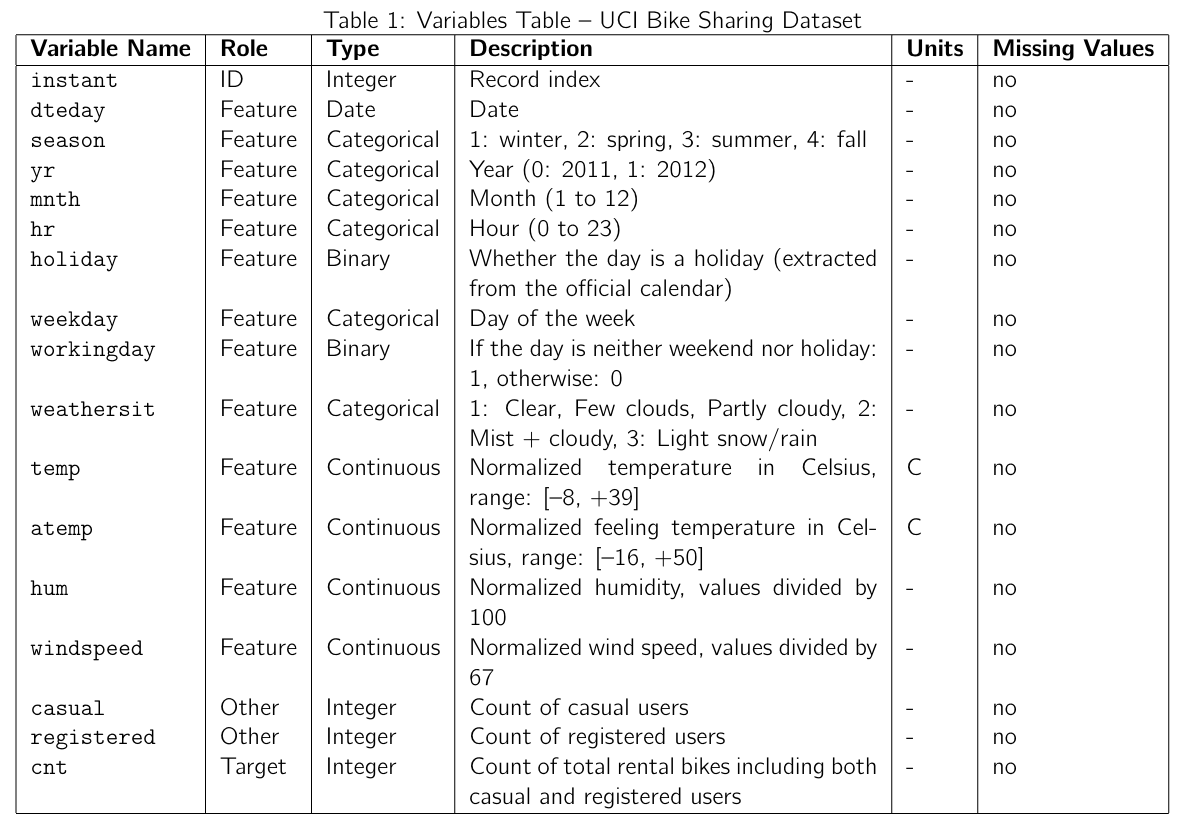

In [6]:
from IPython import display
display.Image("info.png")

Based on the dataset, there are 16 columns, including the target variable (cnt). Three columns (instant, casual, and registered) are labeled as 'other' or 'ID', meaning they are not true features, leaving us with 13 actual features:

- 4 are continuous (temp, atemp, hum, windspeed).
- 6 are categorical (season, yr, mnth, hr, weekday, weathersit).
- 2 are binary (holiday, workingday).
- 1 is a date (dteday).
It also nice to know right off the bat that there are no missing values in the dataset, which means that no data imputation will be required. 

Additionally, analyzing the descriptions of the columns, there are a few that are redundant or simply don't provide any helpful information. I am considering dropping the following columns: 

- instant: The ID is useless, it is just an index. 
- dteday: The date is not relevant since we are given the "category" in other columns
- holiday, weekday, workingday: These three are redundant so it would be smart to choose to keep 1 or 2. 
- casual and registered: I can keep one since it will tell me what the other one is, or I can remove it since it is irrelevant to our objective (Prediction of bike rental count hourly based on the environmental and seasonal settings)

To make sure that I make the best decision, I will analyze a few of them a bit more.

First, we have to take to take a look at the distribution of the target variable to better understand its shape and check for outliers. 

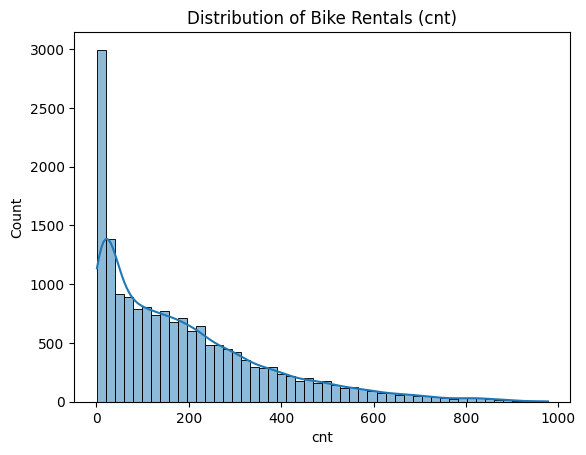

Skewness: 1.2774116037490577


In [ ]:
sns.histplot(df['cnt'], kde=True, bins=50)
plt.title('Distribution of Bike Rentals (cnt)')
plt.show()

print("Skewness:", df['cnt'].skew())


The graph and the skewness value (1.27) show that the target variable has a right-skewed distribution. This means that if we use a linear model we may have to use a transformation. However, other models can handle the skewness well without sacrificing generlaizaton (I will elaborate on this later). This also means that we're gonna have to be careful in the splitting process so that all sets are representative of the full range of data points to avoid bias. 

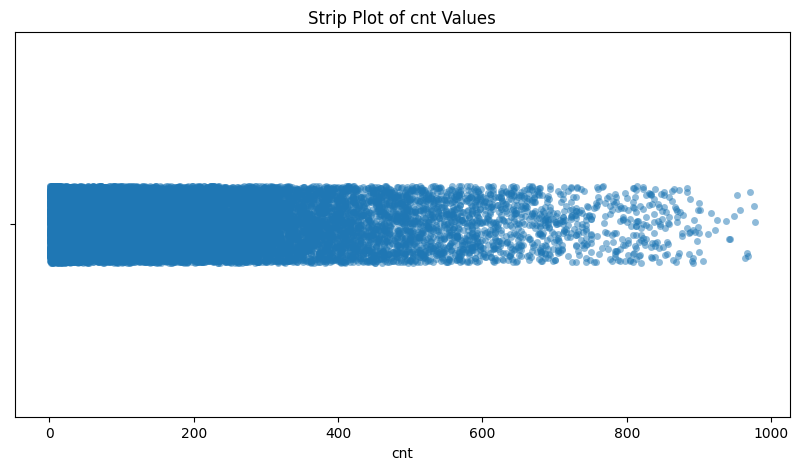

In [ ]:
plt.figure(figsize=(10, 5))
sns.stripplot(x=df["cnt"], jitter=True, alpha=0.5)  # `jitter` spreads points slightly
plt.title("Strip Plot of cnt Values")
plt.show()


With the strip plot above I wanted to see if I was able to spot any extreme outliers since in the bar plot it was not visible no matter the number of bins I chose. As seen in the bar graph, the distribution is heavily right-skewed, with a high density of lower values and a sharp decrease in frequency as values increase. No points exceed 1000, and there is a noticeable drop in density for values above 900. These could be considered possible outliers, but further analysis is required. 

I will calculate the IQR and print those data points that exceed the upper bound, which will idenitfy extreme outliers. 

In [53]:
Q1 = df["cnt"].quantile(0.25)
Q3 = df["cnt"].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + (2.7 * IQR)  

outliers = df[df["cnt"] > upper_bound]
print(outliers[["instant", "dteday", "cnt", "temp", "hum", "windspeed"]]) 

       instant      dteday  cnt  temp   hum  windspeed
10622    10623  2012-03-23  957  0.72  0.42     0.1642
14293    14294  2012-08-23  941  0.74  0.48     0.2239
14725    14726  2012-09-10  968  0.62  0.35     0.2985
14748    14749  2012-09-11  970  0.70  0.28     0.0000
14773    14774  2012-09-12  977  0.66  0.44     0.2537
14964    14965  2012-09-20  976  0.64  0.50     0.2239
15084    15085  2012-09-25  967  0.66  0.39     0.2836
15108    15109  2012-09-26  953  0.74  0.48     0.2985
15444    15445  2012-10-10  948  0.58  0.43     0.2239
15588    15589  2012-10-16  943  0.52  0.39     0.1940
15756    15757  2012-10-23  938  0.68  0.41     0.0000
15780    15781  2012-10-24  963  0.66  0.47     0.0000


The results show 12 potential outliers, which is a small number considering the size of the dataset. I suspect that keeping or removing these 12 points won’t significantly impact the overall distribution. However, to confirm this, I will plot the distribution with and without the outliers and print the summary statistics to have a clearer understanding. 

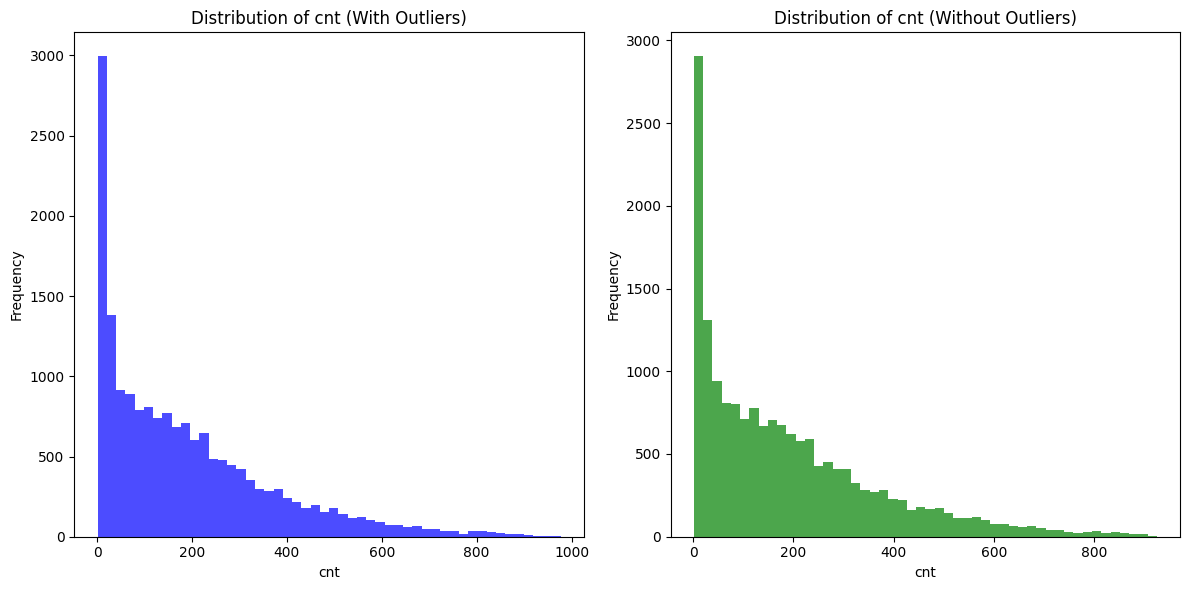

In [45]:
### CREATED WITH CHATGPT ###

df_no_outliers = df[df["cnt"] <= upper_bound]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df["cnt"], bins=50, color='blue', alpha=0.7)
plt.title("Distribution of cnt (With Outliers)")
plt.xlabel("cnt")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(df_no_outliers["cnt"], bins=50, color='green', alpha=0.7)
plt.title("Distribution of cnt (Without Outliers)")
plt.xlabel("cnt")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [46]:
original_stats = df["cnt"].describe()
cleaned_stats = df_no_outliers["cnt"].describe()

original_mean = df["cnt"].mean()
cleaned_mean = df_no_outliers["cnt"].mean()

original_median = df["cnt"].median()
cleaned_median = df_no_outliers["cnt"].median()

original_std = df["cnt"].std()
cleaned_std = df_no_outliers["cnt"].std()

original_skew = df["cnt"].skew()
cleaned_skew = df_no_outliers["cnt"].skew()

print("Original Data Statistics:")
print(f"Mean: {original_mean}, Median: {original_median}, Std: {original_std}, Skew: {original_skew}")

print("\nCleaned Data Statistics:")
print(f"Mean: {cleaned_mean}, Median: {cleaned_median}, Std: {cleaned_std}, Skew: {cleaned_skew}")


Original Data Statistics:
Mean: 189.46308763450142, Median: 142.0, Std: 181.38759909186473, Skew: 1.2774116037490577

Cleaned Data Statistics:
Mean: 188.93176714458457, Median: 142.0, Std: 180.31974431300907, Skew: 1.2563408640704234


The results show minimal impact from keeping or removing the outliers. The mean, median, and standard deviation remain almost unchanged, although there is a slight difference of about 0.02 in skewness, which may suggest that removing the outliers could lead to a slightly more symmetrical distribution. However, I don't believe the impact is significant enough to remove the outliers.

Now, let's move to analyzing the relationship between the target and other variables. It is important to see these relationships not only for correlation, but becuase we have a few temporal variables which may affect our target variable significantly.
- hr: Important to analyze because rentals are definitely affected by the time of the day and this will reveal interesting patterns such as peak hours.
- weekday: Rentals are probably also affected by the day of the week (weekday or weekend). It will reveal if rentals are more common for trips on the weekend or for transportation to work/school in weekdays. 
- mnth: Again, the month will probably have an impact on rentals since maybe during the colder months rentals decrease while in warmer months they probably increase.
- season: Directly related to the month, as seasons (spring, summer, fall, winter) are determined by the month. 

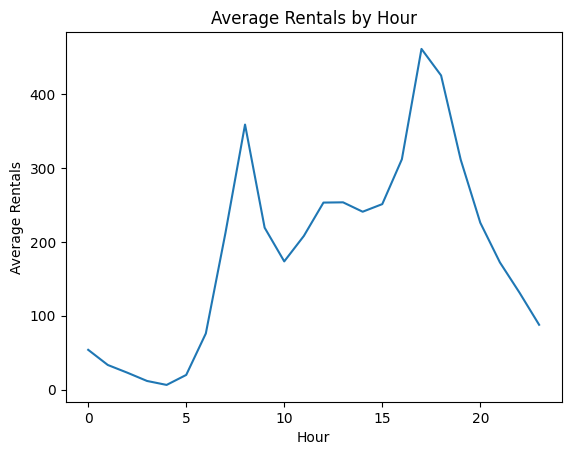

In [54]:
df.groupby('hr')['cnt'].mean().plot(kind='line', title='Average Rentals by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Rentals')
plt.show()

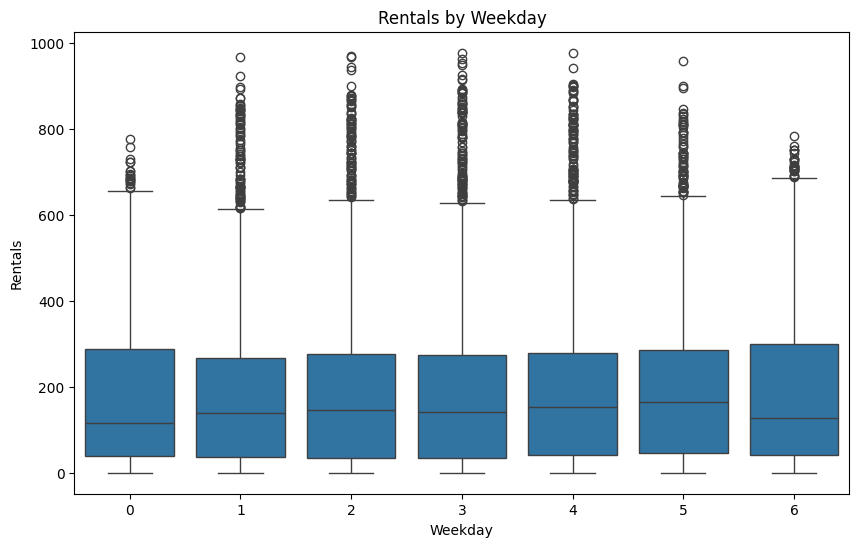

In [55]:
plt.figure(figsize=(10,6))
sns.boxplot(x='weekday', y='cnt', data=df)
plt.title('Rentals by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Rentals')
plt.show()

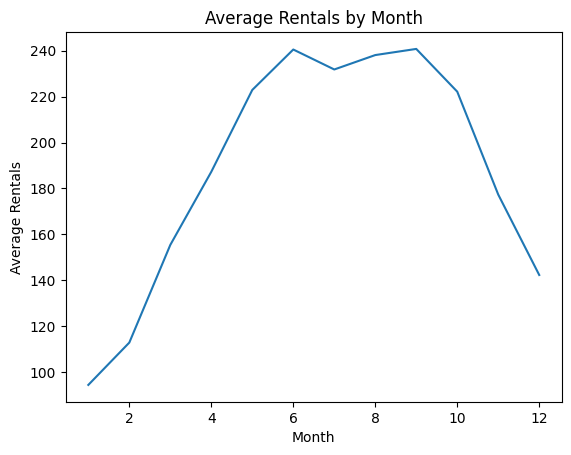

In [56]:
df.groupby('mnth')['cnt'].mean().plot(kind='line', title='Average Rentals by Month')
plt.xlabel('Month')
plt.ylabel('Average Rentals')
plt.show()

# <font color='#3c3c3c'>Task 2</font>

# <font color='#3c3c3c'>Task 3</font>

# <font color='#3c3c3c'>Task 4</font>

# <font color='#3c3c3c'>Task 5</font>

# <font color='#3c3c3c'>Task 6</font>

# <font color='#3c3c3c'>Task 7</font>

# <font color='#3c3c3c'>Task 8</font>

# <font color='#3c3c3c'>Task 9</font>